### Support Vector Machines (SVMs)
- A set of supervised learning methods for classification, regression & outlier detection.
- Effective in **high-dimensional** data problems.
- **Memory-efficient**: it uses a training data subset.
- **Flexible**: can be adapted to use different kernel functions, both standard & custom.
- If #features >> #samples, SVMs can be prone to overfitting. The proper kernel function & regularization term is key.
- SVM need (expensive) cross-validaton techniques to provide probability estimates.
- Scikit-Learn implementation supports both dense & sparse datatypes. For optimal performance, use C-ordered `numpy.ndarray` or `scipy.sparse.csr_matrix` data with `dtype=float64`.

### SVM Classification
- Variants: [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC), [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).
- SVC & NuSVC have slightly different math backgrounds & parameter sets
- LinearSVC is faster, and only supports linear kernels.
- All 3 variants accept a training set X (#samples,#features) and labels y (#samples - strings or integers)

In [2]:
from sklearn import svm
X,y = [[0,0],[1,1]], [0,1]
clf = svm.SVC(); clf.fit(X,y)

print(clf.predict([[2.0,2.0]]))
print(clf.support_) # support vectors (training data subset)
print(clf.n_support_)

[1]
[0 1]
[1 1]


### Example: plot max margin separating hyperplane
- For a 2-class dataset
- Use SVC, linear kernel

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [8]:
# 40 separable points
X, y = make_blobs(n_samples=40, 
                  centers=2, 
                  random_state=6)

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

# create grid to evaluate the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
# ravel: return contiguous flattened array
# T: return transposed array
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

In [11]:
print(xx.shape, yy.shape)
print(XX.shape, YY.shape)
print(xy.shape)
print(Z.shape)

(30,) (30,)
(30, 30) (30, 30)
(900, 2)
(30, 30)


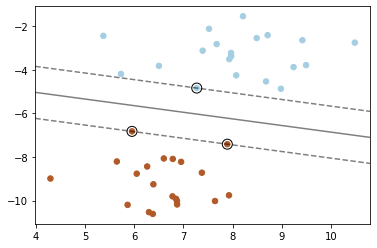

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plot decision boundary
ax.contour(XX, YY, Z, 
           colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], 
           clf.support_vectors_[:, 1], 
           s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Example: binary classification, non-linear (RBF kernel)
- Plot the learned decision function. The goal is to predict the XOR of the inputs.

In [13]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

print(xx.shape,yy.shape)
print(X.shape,Y.shape)

(500, 500) (500, 500)
(300, 2) (300,)


In [15]:
clf = svm.NuSVC(gamma='auto'); clf.fit(X, Y)

# numpy c_: translate slice objects to concat along 2nd axis

print(np.c_[np.array([1,2,3]), np.array([4,5,6])])

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

[[1 4]
 [2 5]
 [3 6]]


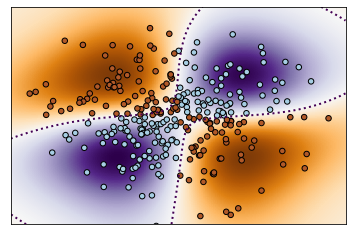

In [16]:
plt.imshow(Z, 
           interpolation='nearest',
           extent=(xx.min(), xx.max(), 
                   yy.min(), yy.max()), 
           aspect='auto',
           origin='lower', 
           cmap=plt.cm.PuOr_r)

contours = plt.contour(xx, yy, Z, 
                       levels=[0], 
                       linewidths=2,
                       linestyles='dotted')

plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

### Example: SVM - univariate feature selection
- How to do univariate feature selection before running an SVC to improve classification scores.
- Iris dataset (4 features) + 36 non-informative features.
- Expect to find best scores when we select ~10% of the features.

In [17]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score as CVS
from sklearn.pipeline import Pipeline as Pipe
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC

In [18]:
X, y = load_iris(return_X_y=True)
np.random.seed(0)
# add non-informative features
X = np.hstack((X, 2*np.random.random((X.shape[0], 36))))

In [20]:
# Create a pipeline:
# - feature-selection transform
# - a scaler
# - an instance of SVM
clf = Pipe([('anova', SelectPercentile(chi2)),
            ('scaler', SS()),
            ('svc', SVC(gamma="auto"))])

In [21]:
# plot CV score as function(% of features)
score_means, score_stds = list(), list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

In [22]:
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = CVS(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

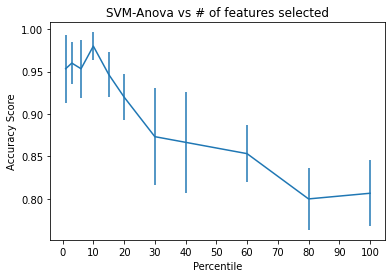

In [23]:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('SVM-Anova vs # of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

### Multiclass classification (SVC, NuSVC)
- SVC & NuSVC use **one-vs-one** approach.
    - `#classes*(#classes-1)/2` classifiers are built; each trains itself with data from two classes.
    - you can use `decision_function_shape` to transform the results of a OvO classifier into a OvR function of shape `(#samples,#classes)`.
- LinearSVC uses a **one-vs-rest** approach. OvR returns `coef_` (#classes,#features) and `intercept_` (#classes) attributes.

In [25]:
X = [[0], [1], [2], [3]]
Y = [0,    1,   2,   3]

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y)
dec = clf.decision_function([[1]])
print(dec.shape[1]) # 4 classes: 4*3/2 = 6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
print(dec.shape[1]) # 4 classes

lin_clf = svm.LinearSVC()
lin_clf.fit(X, Y)
dec = lin_clf.decision_function([[1]])
print(dec.shape[1])

6
4
4


### Scoring & Probabilities
- The `decision_function` method returns per-class scoring for each sample.
- If the constructor option `probability` is `True`, class membership probabilities are enabled.
- Binary classificaton: probabilities are calculated using *Platt scaling* (logistic regression on SVM scoring, fit with an additional cross-validation step.)
- Note: Platt's method known to have theoretical issues. Therefore advisable to set `probability=False` and use `decision_function` instead of `predict_proba`.

### Weighted Classes
- Use `class_weight` and `sample_weight` params when you need to assign more importance to selected classes.
- **SVC** implements `class_weight` when fitting. It's a dictionary of `{class_label : value}`, where value is a floating point number > 0. It sets the `C` of `class_label` to `C*value`.

### Example: SVC, unbalanced classes

In [26]:
# we create two clusters of random points
n_samples_1, n_samples_2  = 1000,100
centers      = [[0.0, 0.0], [2.0, 2.0]]
clusters_std =  [1.5,        0.5]

X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [27]:
clf = svm.SVC(kernel='linear', C=1.0)
wclf = svm.SVC(kernel='linear', class_weight={1: 10})

clf.fit(X,y); wclf.fit(X,y)

SVC(class_weight={1: 10}, kernel='linear')

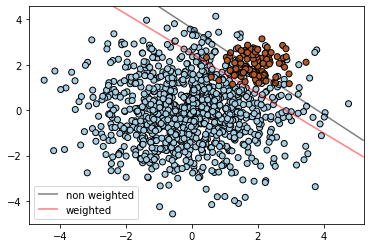

In [29]:
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, 
               colors='k', levels=[0], 
               alpha=0.5, linestyles=['-'])

# separating hyperplane - weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins (weighted)
b = ax.contour(XX, YY, Z, 
               colors='r', levels=[0], 
               alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], 
            b.collections[0]], 
           ["non weighted", "weighted"],
           loc="lower left")
plt.show()

### Weighted Samples
- SVC/SVR, NuSVC/NuSVR, LinearSVC/SVR, OneClassSVM all support individual sample weights during `fit`ting via the `sample_weight` param.
- It sets `C` for the ith sample to `C*sample_weight[i]`.

### Example - weighted samples
- To emphasize the effect we prioritize *outliers*. This makes the decision boundary deformation very visible.

In [30]:
def plot_decision_function(classifier, sample_weight, axis, title):

    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), 
                         np.linspace(-4, 5, 500))
    Z = classifier.decision_function(np.c_[xx.ravel(), 
                                           yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot line, points & nearest vectors to the plane
    axis.contourf(xx, yy, Z, 
                  alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], 
                 X[:, 1], 
                 c=y, s=100*sample_weight, 
                 alpha=0.9,
                 cmap=plt.cm.bone, 
                 edgecolors='black')

    axis.axis('off')
    axis.set_title(title)

In [31]:
# Create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], 
          np.random.randn(10, 2)]
y = [1]*10 + [-1]*10

sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9]   *= 15

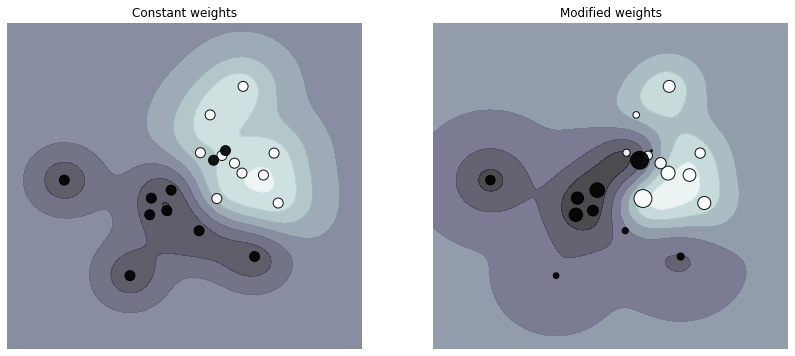

In [32]:
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, 
                sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, 
                       sample_weight_constant, 
                       axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, 
                       sample_weight_last_ten, 
                       axes[1],
                       "Modified weights")
plt.show()